In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

In [3]:
import pandas as pd

def find_plateau_timestep(return_series, window=10, threshold=0.01):
    """
    Find the timestep at which the learning plateaued.

    Parameters:
        return_series (list or np.ndarray): Series of returns from the agent.
        window (int): Window size for the moving average and gradient check.
        threshold (float): Threshold for improvement to consider plateau.

    Returns:
        int: Timestep (index) where the learning plateaued, or -1 if no plateau detected.
    """
    # Convert series to a NumPy array for efficiency
    returns = np.array(return_series)
    
    # Compute the moving average to smooth the series
    smoothed = pd.Series(returns).rolling(window=window, min_periods=1).mean().values
    
    # Compute the gradient of the smoothed series
    gradient = np.gradient(smoothed)
    
    # Check the gradient over a sliding window
    for i in range(len(gradient) - window + 1):
        # Look at the gradient over the next 'window' timesteps
        if np.all(gradient[i:i + window] < threshold):
            return i  # Return the index where the plateau starts
    
    return -1  # Return -1 if no plateau is found

def get_intersection(ve1, v01, ve2, v02, max_weight=10):
    # handle division by zero masking out the positions where the denominator is zero
    denominator = ve2 - ve1
    if isinstance(denominator, np.ndarray):
        denominator[denominator == 0] = np.nan
    else:
        if denominator == 0:
            return np.nan
    wes = (v01 - v02) / denominator
    return np.round(wes[(wes >= 0) & (wes <= max_weight)], 2)

In [4]:
def get_metrics(path):
    metrics = json.load(open(path+"/metrics.json"))
    return metrics

def plot_metric(key, metrics, title=""):
    steps = metrics[key]["steps"]
    values = metrics[key]["values"]
    plt.plot(steps, values)
    plt.xlabel("steps")
    plt.ylabel(key)
    plt.title(title)

def plot_mean_return(metrics, title="Mean Return of all agents"):
    steps = metrics["total_return_mean"]["steps"]
    mean_return = np.array(metrics["total_return_mean"]["values"])
    window = 100
    plateau = find_plateau_timestep(mean_return, window=window, threshold=0.1)
    if plateau != -1:
        plateau_step = steps[plateau]
        plt.axvline(plateau_step, color="black", linestyle="--", label=f"Plateau at {plateau_step}")
        avg = mean_return[plateau:].mean()
    else: 
        avg = mean_return[-window:].mean()
    plt.axhline(avg, color="red", linestyle="--", label=f"Average: {avg:.2f}", zorder=10)
    plt.plot(steps, mean_return)
    
    # add avg to yticks
    yticks = plt.yticks()[0]
    yticks = np.append(yticks, avg)
    plt.yticks(yticks)
    plt.xlabel("steps")
    plt.ylabel("mean return")
    plt.title(title)
    
def plot_all_agents_mean_return(metrics, title="Mean Return per agent"):
    steps = metrics["total_return_mean"]["steps"]
    ag = 0
    while True:
        try:
            values = metrics[f"agent_{ag}_return_mean"]["values"]
        except:
            break 
        plt.plot(steps, values, label=f"Agent {ag}")
        plt.xlabel("steps")
        plt.ylabel("mean return")
        plt.title(title)
        plt.legend()
        ag += 1
        
def plot_individual_objective_per_agent(metrics, title="Individual Objective per agent"):
    steps = metrics["agent_0_objective_1_return_mean"]["steps"]
    ag = 0
    while True:
        try:
            values = metrics[f"agent_{ag}_objective_1_return_mean"]["values"]
        except:
            break 
        plt.plot(steps, values, label=f"Agent {ag}")
        plt.xlabel("steps")
        plt.ylabel("Individual return")
        plt.title(title)
        plt.legend()
        ag += 1
    
def plot_ethical_objective_per_agent(metrics, title="Ethical Objective per agent"):
    steps = metrics["agent_0_objective_0_return_mean"]["steps"]
    ag = 0
    while True:
        try:
            values = metrics[f"agent_{ag}_objective_0_return_mean"]["values"]
        except:
            break 
        plt.plot(steps, values, label=f"Agent {ag}")
        plt.xlabel("steps")
        plt.ylabel("Ethical Return")
        plt.title(title)
        plt.legend()
        ag += 1
        
def plot_combined_objectives(metrics, title="Combined Objectives"):
    steps = metrics["agent_0_objective_0_return_mean"]["steps"]
    ind_values = []
    eth_values = []
    ag = 0
    while True:
        try:
            ind_values.append(np.array(metrics[f"agent_{ag}_objective_1_return_mean"]["values"]))
            eth_values.append(np.array(metrics[f"agent_{ag}_objective_0_return_mean"]["values"]))
        except:
            break
        ag += 1
    
    ind_values = np.array(ind_values).mean(axis=0)
    eth_values = np.array(eth_values).mean(axis=0)
    print(eth_values.shape)
    # Plot the two objectives in subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(steps, ind_values, label="Individual")
    axs[0].set_title("Individual Objective")
    axs[0].set_xlabel("steps")
    axs[0].set_ylabel("Individual Return")
    
    axs[1].plot(steps, eth_values, label="Ethical")
    axs[1].set_title("Ethical Objective")
    axs[1].set_xlabel("steps")
    axs[1].set_ylabel("Ethical Return")
    
def plot_combined_objectives_per_agent(metrics, title="Combined Objectives"):
    steps = metrics["agent_0_objective_0_return_mean"]["steps"]
    ind_values = []
    eth_values = []
    ag = 0
    while True:
        try:
            ind_values.append(np.array(metrics[f"agent_{ag}_objective_1_return_mean"]["values"]))
            eth_values.append(np.array(metrics[f"agent_{ag}_objective_0_return_mean"]["values"]))
        except:
            break
        ag += 1
    
    ind_values = np.array(ind_values)
    eth_values = np.array(eth_values)
    print(eth_values.shape)
    # Plot the two objectives in subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for i in range(ind_values.shape[0]):
        axs[0].plot(steps, ind_values[i], label=f"Agent {i}")
    axs[0].set_title("Individual Objective")
    axs[0].set_xlabel("steps")
    axs[0].set_ylabel("Individual Return")
    
    for i in range(eth_values.shape[0]):
        axs[1].plot(steps, eth_values[i], label=f"Agent {i}")
    axs[1].set_title("Ethical Objective")
    axs[1].set_xlabel("steps")
    axs[1].set_ylabel("Ethical Return")
        
def plot_grad_norm(metrics, tittle="Grad norm"):
    steps = metrics["agent_grad_norm"]["steps"]
    values = metrics["agent_grad_norm"]["values"]
    plt.plot(steps, values)
    plt.xlabel("steps")
    plt.ylabel("grad norm")
    plt.title(tittle)


In [5]:
reference = "beegfs/EPyMARL/sacred/lippo_egg/MultiAgentEthicalGathering-large-mo-v1/5"
validation = "beegfs/EPyMARL/sacred/mappo/MultiAgentEthicalGathering-large-v1/3"
deployed = "beegfs/EPyMARL/sacred/ippo_egg/MultiAgentEthicalGathering-large-v1/5"

(5, 1001)


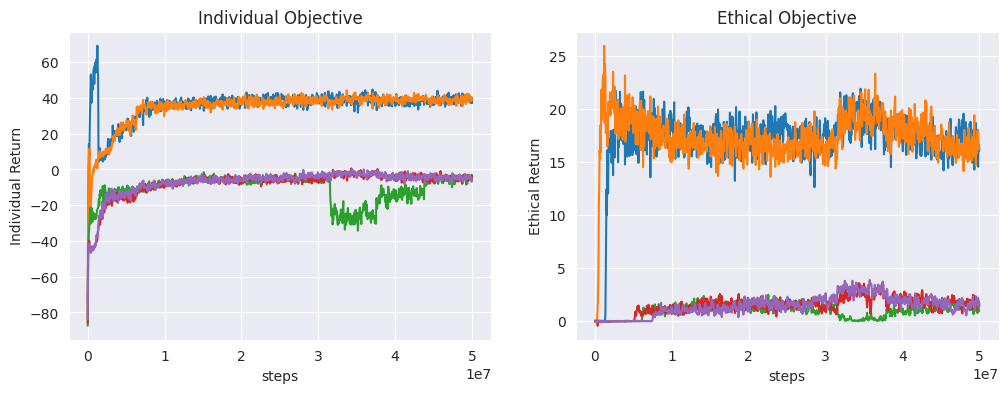

In [6]:
metrics = get_metrics(reference)
plot_combined_objectives_per_agent(metrics)

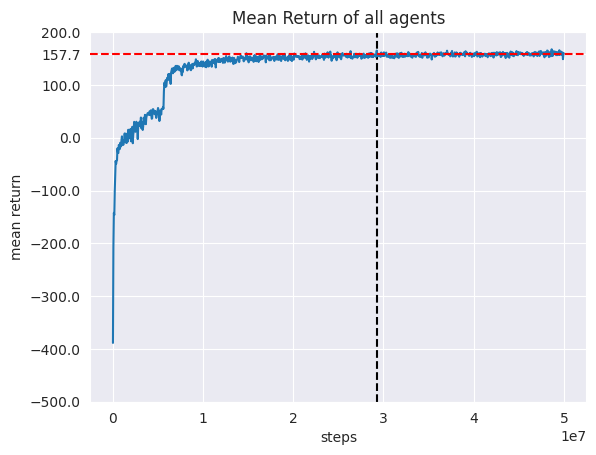

In [7]:
metrics = get_metrics(validation)
plot_mean_return(metrics)

In [8]:
plot_combined_objectives_per_agent(metrics,3)

KeyError: 'agent_0_objective_0_return_mean'

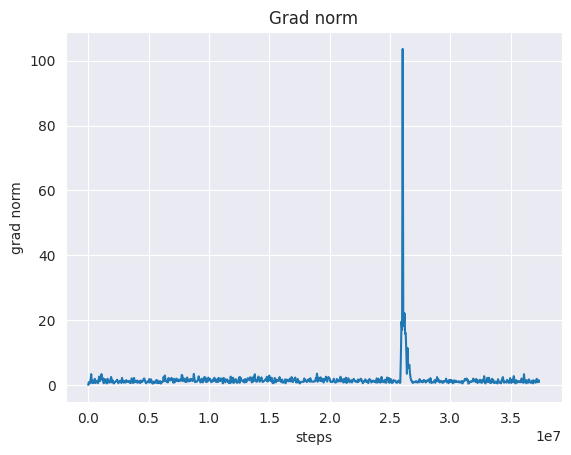

In [44]:
plot_grad_norm(metrics)

Agent, 		 ref[0],	 ref[1],	 unet[0],	 unet[1]
Agent 	0, 	15.3, 	36.89, 	0.0, 	52.14
Agent 	1, 	15.28, 	36.82, 	0.0, 	55.61
Agent 	2, 	1.58, 	-1.0, 	0.0, 	-4.38
Agent 	3, 	1.44, 	-0.86, 	0.0, 	-6.17
Agent 	4, 	1.62, 	-1.07, 	0.0, 	-4.3
[1.]
[1.23]
[]
[]
[]


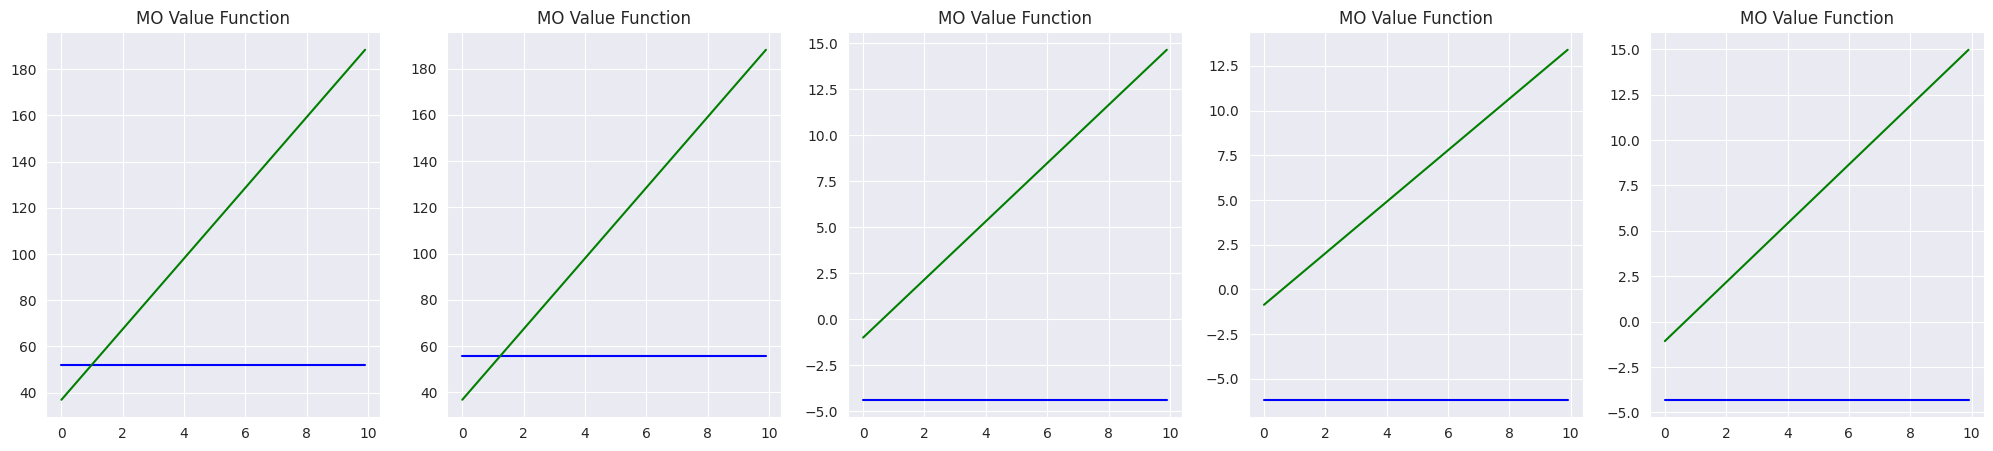

In [9]:
# OLS
ref = np.array([[15.3 , 36.89],
 [15.28, 36.82],
 [ 1.58, -1.  ],
 [ 1.44, -0.86],
 [ 1.62, -1.07]])
unet = np.array([
[-16.07,  52.14],
[-15.76,  55.61],
 [ -3.45,  -4.38],
 [ -3.11,  -6.17],
 [ -3.16,  -4.3 ]])
#unet = policies[0.4][0]
unet[:, 0] = 0 

fig, axs = plt.subplots(1, 5, figsize=(25, 5)) 
step = 0.1
# for ag in mo_value_w10:
max_weight = 10
# Subplot for each agent
x = np.arange(0, max_weight, step)
w = np.array([np.arange(0, max_weight, step), np.ones(int(max_weight/step))])

print("Agent, \t\t ref[0],\t ref[1],\t unet[0],\t unet[1]")
for i, ag in enumerate(range(5)):
    # Print lines like: Agent i, ref[0], ref[1], unet[0], unet[1]
    print(f"Agent \t{ag}, \t{ref[ag, 0]}, \t{ref[ag, 1]}, \t{unet[ag, 0]}, \t{unet[ag, 1]}")

for i, ag in enumerate(range(5)):
    axs[i].set_title("MO Value Function")
    axs[i].plot(x, np.dot(unet[ag], w), c="blue")
    axs[i].plot(x, np.dot(ref[ag], w), c="green")
    
wes = []
for ag in range(5):
    # Print intersecctions
    inter = get_intersection(unet[ag, 0], unet[ag, 1], ref[ag, 0], ref[ag, 1], max_weight=max_weight)
    print(inter)
    wes.append(inter)
plt.show()